# Regressor Model for Predicting Ventricular ICV

In [1]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.io import loadmat

### Get Features (FC Matrices)

In [47]:
ADNI_MERGE_WITH_VENTRICULAR_VOL = '../data/ADNIMERGE/ADNIMERGE_29Apr2024_Ventricles_ICV.csv'

df = pd.read_csv(ADNI_MERGE_WITH_VENTRICULAR_VOL)

# Try adding abeta and tau biomarkers

df = df[['RID', 'VISCODE', 'Ventricles_ICV', 'ABETA', 'TAU', 'DX', 'DX_bl', 'FC_DATA']]
# df = df.dropna(subset=['Ventricles_ICV', 'ABETA', 'TAU'])
df = df.dropna(subset=['Ventricles_ICV'])

df = df.reset_index(drop=True)
# df['ABETA'] = df['ABETA'].replace('>1700', '1700')
df.head()

,RID,VISCODE,Ventricles_ICV,ABETA,TAU,DX,DX_bl,FC_DATA
0,5280,M024,0.022327,NaN,NaN,CN,SMC,../FMRI_ADNI_DATA/fc/sub-ADNI100S5280_ses-M024...
1,5265,M024,0.044713,376.8,266.5,CN,SMC,../FMRI_ADNI_DATA/fc/sub-ADNI007S5265_ses-M024...
2,5262,M000,0.020445,NaN,NaN,CN,SMC,../FMRI_ADNI_DATA/fc/sub-ADNI018S5262_ses-M000...
3,5250,M000,0.011622,NaN,NaN,CN,SMC,../FMRI_ADNI_DATA/fc/sub-ADNI018S5250_ses-M000...
4,5242,M000,0.009847,1306,302.5,CN,SMC,../FMRI_ADNI_DATA/fc/sub-ADNI019S5242_ses-M000...


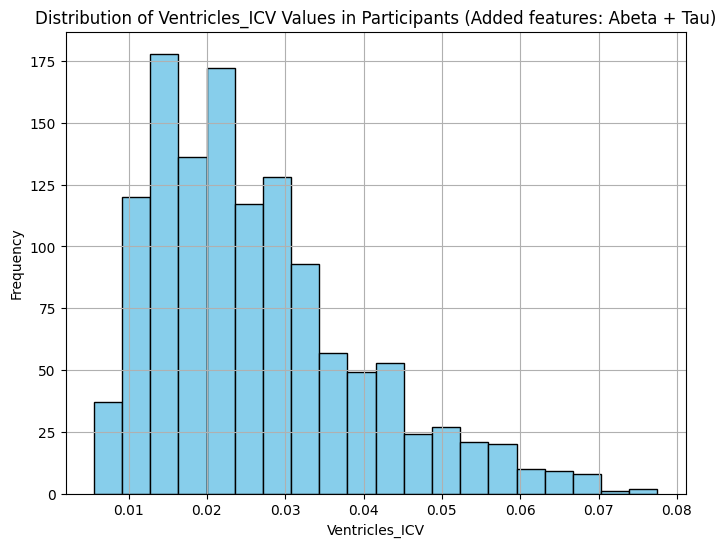

In [48]:
plt.figure(figsize=(8, 6))
plt.hist(df['Ventricles_ICV'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ventricles_ICV Values in Participants (Added features: Abeta + Tau)')
plt.xlabel('Ventricles_ICV')
plt.ylabel('Frequency')
plt.grid(True)
plt.axis('on')
# plt.savefig('../data/ventricles_ICV_dist_20bins_abeta_tau_sample.png')

plt.show()

In [38]:
def compute_fc_lower_triangle(fmri, node_size):
    # Calculate the z_score (along the time axis)
    fmri_zscored = (fmri.T - fmri.mean(axis=1)) / fmri.std(axis=1)

    # Calculate the FC 
    fc = np.corrcoef(fmri_zscored.T)
    
    # Get the lower triangle
    mask_e = np.tril_indices(node_size, -1)
    lower_triangle = fc[mask_e]
    
    return lower_triangle

In [5]:
# df.loc[2, 'ABETA']

In [49]:
dim_x = len(df)
X = []
NODE_SIZE = 100

for i, file in enumerate(df['FC_DATA'].values):
    arr = loadmat(f'../{file}')['ROI_activity'][:NODE_SIZE, :] # get the first 100 regions 
    fc = compute_fc_lower_triangle(arr, NODE_SIZE)
    # add abeta and tau features too
#     add_features = np.asarray([float(df.loc[i, 'ABETA']), float(df.loc[i, 'TAU'])])
#     features = np.concatenate((add_features, fc), axis=0)
    X.append(fc)
    
X = np.array(X)
print(X.shape)

Y = df['Ventricles_ICV']
print(Y.shape)

(1262, 4950)
(1262,)


In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Train Regressor Model

In [52]:
def getGBMRegressor():
    #Configure GBM regression model
    params = {"subsample": 0.81, "n_estimators": 500, "min_samples_split": 5, "max_features": "sqrt", "max_depth": 2, "learning_rate": 0.05, 'loss':'huber'}
    reg = GradientBoostingRegressor(**params)
    return reg, 'gbm'

def getRFRegressor():
    return  RandomForestRegressor(n_estimators=500, max_depth=None, random_state=0, bootstrap=True), 'rf'

In [19]:
# from sklearn.decomposition import PCA

# print('x_train shape: ', X_train.shape)
# print('x_test shape: ', X_test.shape)

# pca = PCA(n_components=250)  # Specify the number of components (desired dimensionality)
# X_train_reduced = pca.fit_transform(X_train)
# print('x_train shape (reduced): ', X_train_reduced.shape)

# X_test_reduced = pca.fit_transform(X_test)
# print('x_train shape (reduced): ', X_test_reduced.shape)

In [53]:
reg, type = getGBMRegressor()  
reg.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=2,
                          max_features='sqrt', min_samples_split=5,
                          n_estimators=500, subsample=0.81)

In [54]:
y_pred = reg.predict(X_test)
mae = np.mean(np.abs(Y_test - y_pred))
spearman_rho = spearmanr(Y_test, y_pred)[0]
r2 = r2_score(Y_test, y_pred)

print('METRICS FOR GBM REGRESSOR MODEL:')
print('MAE: ', mae)
print('Spearman rho: ', spearman_rho)
print('R2: ', r2)

METRICS FOR GBM REGRESSOR MODEL:
MAE:  0.00874280958685373
Spearman rho:  0.45206305733522445
R2:  0.18270903572320707


Text(0.5, 1.0, 'GBM Regressor: Ventricular_ICV Predictions')

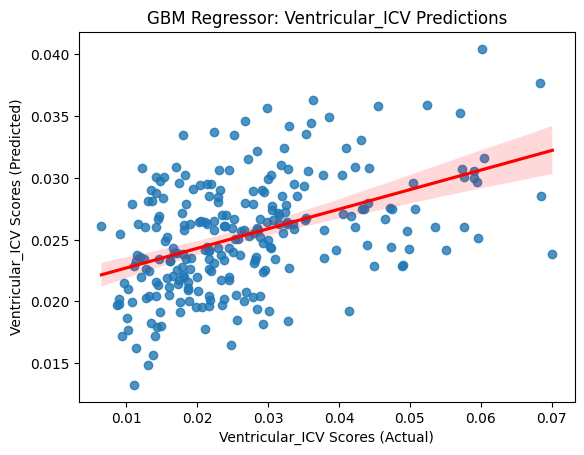

In [55]:
sns.regplot(x=Y_test, y=y_pred, line_kws={'color':'red'})
plt.xlabel('Ventricular_ICV Scores (Actual)')  # Replace 'X Axis Label' with the label for your x-axis
plt.ylabel('Ventricular_ICV Scores (Predicted)')  # Replace 'Y Axis Label' with the label for your y-axis
plt.title('GBM Regressor: Ventricular_ICV Predictions')   # Replace 'Scatter Plot' with the title for your plot

# plt.savefig('ventricular_gbm_regressor_hyperparam_tuned.png')


In [30]:
# Saving the regressor model
import pickle

model_filename = 'gbregressor_ventricular_icv.pkl'

# with open(model_filename, 'wb') as f:
#     pickle.dump(reg, f)

In [51]:
with open(model_filename, 'rb') as f:
    gbm = pickle.load(f)

y_pred = gbm.predict(X_test)
mae = np.mean(np.abs(Y_test - y_pred))
spearman_rho = spearmanr(Y_test, y_pred)[0]
r2 = r2_score(Y_test, y_pred)

print('METRICS FOR LOADED GBM REGRESSOR MODEL:')
print('MAE: ', mae)
print('Spearman rho: ', spearman_rho)
print('R2: ', r2)

METRICS FOR LOADED GBM REGRESSOR MODEL:
MAE:  0.008743922426164343
Spearman rho:  0.45529387877898664
R2:  0.20348670380411538


## Hyperparameter Tuning: Random Search 

In [196]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
gbm = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'max_depth': [2, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'subsample': np.arange(0.01, 1.0, 0.05),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Set Up Randomized Search
random_search = RandomizedSearchCV(estimator=gbm, param_distributions=param_grid,
                                   n_iter=100, cv=5, verbose=2, random_state=42,
                                   n_jobs=-1, scoring='r2')

# Fit the random search model
random_search.fit(X_train, Y_train)

# Print the best parameters and best score
print("Best Parameters found: ", random_search.best_params_)
print("Best R² score found: ", random_search.best_score_)

# Evaluate on the test set
y_pred = random_search.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print(f"R² score on test set: {r2:.2f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
